# Black-box model aproximation

The purpose of this notebook is to demonstrate the possibility of using RuleXAI to explain black box models. The data set titanic from OpenML (https://www.openml.org/d/40945) was used in the analysis. It is a popular data set often used in various types of examples, therefore it was decided to use it in this analysis.

## Data load

In [48]:
import pandas as pd

data = pd.read_csv('./data/titanic_openml.csv')
data

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29.0000,0,0,24160,211.3375,B5,S,2,NaN,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON"
2,1,0,"Allison, Miss. Helen Loraine",female,2.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1,2,113781,151.5500,C22 C26,S,NaN,135.0,"Montreal, PQ / Chesterville, ON"
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1304,3,0,"Zabour, Miss. Hileni",female,14.5000,1,0,2665,14.4542,NaN,C,NaN,328.0,NaN
1305,3,0,"Zabour, Miss. Thamine",female,NaN,1,0,2665,14.4542,NaN,C,NaN,NaN,NaN
1306,3,0,"Zakarian, Mr. Mapriededer",male,26.5000,0,0,2656,7.2250,NaN,C,NaN,304.0,NaN
1307,3,0,"Zakarian, Mr. Ortin",male,27.0000,0,0,2670,7.2250,NaN,C,NaN,NaN,NaN


## Dataset overwiev

In [49]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   pclass     1309 non-null   int64  
 1   survived   1309 non-null   int64  
 2   name       1309 non-null   object 
 3   sex        1309 non-null   object 
 4   age        1046 non-null   float64
 5   sibsp      1309 non-null   int64  
 6   parch      1309 non-null   int64  
 7   ticket     1309 non-null   object 
 8   fare       1308 non-null   float64
 9   cabin      295 non-null    object 
 10  embarked   1307 non-null   object 
 11  boat       486 non-null    object 
 12  body       121 non-null    float64
 13  home.dest  745 non-null    object 
dtypes: float64(3), int64(4), object(7)
memory usage: 143.3+ KB


In [50]:
data[['survived', 'pclass']
     ] = data[['survived', 'pclass']].astype(str)

In [51]:
numeric_data = data[['age', 'sibsp', 'parch', 'fare', 'body']]
caterogical_data = data[['name', 'sex', 'ticket',
                         'cabin', 'embarked', 'boat', 'home.dest']]

In [52]:
numeric_data.describe()

,age,sibsp,parch,fare,body
count,1046.000000,1309.000000,1309.000000,1308.000000,121.000000
mean,29.881135,0.498854,0.385027,33.295479,160.809917
std,14.413500,1.041658,0.865560,51.758668,97.696922
min,0.166700,0.000000,0.000000,0.000000,1.000000
25%,21.000000,0.000000,0.000000,7.895800,72.000000
50%,28.000000,0.000000,0.000000,14.454200,155.000000
75%,39.000000,1.000000,0.000000,31.275000,256.000000
max,80.000000,8.000000,9.000000,512.329200,328.000000


In [53]:
caterogical_data.describe()

,name,sex,ticket,cabin,embarked,boat,home.dest
count,1309,1309,1309,295,1307,486,745
unique,1307,2,929,186,3,27,369
top,"Kelly, Mr. James",male,CA. 2343,C23 C25 C27,S,13,"New York, NY"
freq,2,843,11,6,914,39,64


## Data preprocessing

In the first stage of data preprocessing it was decided to only remove the columns for  Passenger Name, ticket type, cabin, embarked, boat, home.dest, body. Removing the Passenger Name columns is self-explanatory - in no way does Passenger Name have any bearing on whether a person survived. It would only be possible to derive passenger status from passenger name, as there are markings such as ‘Mr.’, ‘Mrs.’, ‘Miss.’, ‘Master.’. In case of tickets, the designations for most tickets vary - 681 unique values out of 891 occurrences. One could extract some information from the tickets from their designations (e.g., whether they begin with a number or a letter). However, you would have to consult historical data to find out what the ticket designations mean. In the case of cabin designations, as many as 697 values are missing - for this reason it was decided to remove the entire column, as it carries too little information. On the basis of a similar analysis, the remaining mentioned columns were removed

Of course, the preliminary data analysis and preprocessing stage itself could have been even more extensive - exploring the relationships between features, examining the impact of individual features, plotting graphs to better understand the data. However, the main purpose of this notebook is not to analyze a given set of data in detail, but only to show the possibilities of using the RuleXAI library. For this reason, some simplifications in the analysis have been decided.

In [54]:
data.drop(["name", "ticket", "cabin", "embarked", "boat", "home.dest", "body"], axis=1, inplace=True)
data.reset_index(inplace=True, drop=True)

data.head(5)

,pclass,survived,sex,age,sibsp,parch,fare
0,1,1,female,29.0000,0,0,211.3375
1,1,1,male,0.9167,1,2,151.5500
2,1,0,female,2.0000,1,2,151.5500
3,1,0,male,30.0000,1,2,151.5500
4,1,0,female,25.0000,1,2,151.5500


## Building black-box model - neural network

In order to demonstrate the possibility of using the RuleXAI library to explain black-box models, it was decided to use the Titanic set to build a neural network to classify whether a given person survived or not. Then, with the help of the RuleXAI library, an analysis will be performed to explain on what basis the neural network model makes decisions.

Since neural networks do not handle missing data and operate only on numerical data, it was necessary to fill in the missing data, perform dummification and scaling.

In [55]:
from sklearn.preprocessing import MinMaxScaler

data.age = data.age.fillna(data.age.median())
data.fare = data.age.fillna(data.fare.median())

scaler = MinMaxScaler()
data_dummies = pd.get_dummies(data.drop(["survived"], axis=1))
data_dummies = data_dummies.drop(["sex_male"], axis=1)
data_scaled = pd.DataFrame(scaler.fit_transform(data_dummies),index=data_dummies.index,columns=data_dummies.columns)

X = data_scaled
y = data.survived.astype(int)

X.head(5)

,age,sibsp,parch,fare,pclass_1,pclass_2,pclass_3,sex_female
0,0.361169,0.000,0.000000,0.361169,1.0,0.0,0.0,1.0
1,0.009395,0.125,0.222222,0.009395,1.0,0.0,0.0,0.0
2,0.022964,0.125,0.222222,0.022964,1.0,0.0,0.0,1.0
3,0.373695,0.125,0.222222,0.373695,1.0,0.0,0.0,0.0
4,0.311064,0.125,0.222222,0.311064,1.0,0.0,0.0,1.0


In [56]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, )

Neural Network learning

In [66]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping

model = Sequential()

model.add(Input(shape=(X_train.shape[1],)))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation="relu"))
model.add(Dense(32, activation="relu"))
model.add(Dense(1, activation="sigmoid"))

model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

early_stopping_callback = EarlyStopping(monitor='val_loss', patience=10)

history = model.fit(X_train.to_numpy(), y_train.to_numpy(), epochs=100, batch_size = 24, validation_split=0.2, callbacks=[early_stopping_callback])

Epoch 1/100
31/31 [==============================] - 0s 16ms/step - loss: 0.6153 - accuracy: 0.7254 - val_loss: 0.5677 - val_accuracy: 0.7446
Epoch 2/100
31/31 [==============================] - 0s 6ms/step - loss: 0.4747 - accuracy: 0.7964 - val_loss: 0.5232 - val_accuracy: 0.7500
Epoch 3/100
31/31 [==============================] - 0s 7ms/step - loss: 0.4416 - accuracy: 0.8033 - val_loss: 0.5081 - val_accuracy: 0.7500
Epoch 4/100
31/31 [==============================] - 0s 5ms/step - loss: 0.4318 - accuracy: 0.8046 - val_loss: 0.5271 - val_accuracy: 0.7500
Epoch 5/100
31/31 [==============================] - 0s 6ms/step - loss: 0.4359 - accuracy: 0.8074 - val_loss: 0.4926 - val_accuracy: 0.7446
Epoch 6/100
31/31 [==============================] - 0s 6ms/step - loss: 0.4364 - accuracy: 0.8033 - val_loss: 0.4932 - val_accuracy: 0.7446
Epoch 7/100
31/31 [==============================] - 0s 6ms/step - loss: 0.4268 - accuracy: 0.8156 - val_loss: 0.4931 - val_accuracy: 0.7554
Epoch 8/100


In [14]:
model.save("./models/nn", save_format = 'h5')

### Model evaluation on training and test set

In [67]:
from sklearn.metrics import balanced_accuracy_score, accuracy_score
import numpy as np

train_acc = np.round(accuracy_score(y_train, model.predict(X_train)>0.5),3)
train_bacc = np.round(balanced_accuracy_score(y_train, model.predict(X_train)>0.5),3)

print(f"NN model train accuracy: {train_acc}")
print(f"NN model train bacc: {train_bacc}")

test_acc = np.round(accuracy_score(y_test, model.predict(X_test)>0.5),3)
test_bacc = np.round(balanced_accuracy_score(y_test, model.predict(X_test)>0.5),3)

print(f"NN model test accuracy: {test_acc}")
print(f"NN model test bacc: {test_bacc}")

NN model train accuracy: 0.816
NN model train bacc: 0.793
NN model test accuracy: 0.809
NN model test bacc: 0.794


Since the purpose of the analysis is not to create the best possible black-box model, but only to show the possibility of its explanation, it was concluded that the model obtaining a balanced accuracy of 0.793 on the training set and 0.794 on the test set is sufficient. Of course, testing other network architectures would yield better results, but that is not the purpose of this notebook.

## RuleXAI

The RuleXAI library enables the explanation of black-box models by approximating the black-box model with a rule model. This is possible by replacing the decision variable in the dataset with decisions made by the network and teaching the rule model on that dataset. The rule-based model will therefore learn to map the data set to the decisions made by the black-box model. It is also worth noting that the rule-based model can then be trained on the original set (containing nominal and missing attributes). Such a procedure will facilitate the analysis. Instead of the conditions Sex_female = {0}, the condition set will have the condition Sex = {male}

In [68]:
import numpy as np

y_train_nn_decisions = np.array(list(map(int, model.predict(X_train)>0.5)))
y_test_nn_decisions = np.array(list(map(int, model.predict(X_test)>0.5)))

y_train_nn_df = pd.DataFrame(y_train_nn_decisions, columns=["label"]).astype(str)

X_org = data.drop(["survived"], axis=1)
y_org = data.survived

X_train_org = X_org.loc[X_train.index,:]
X_test_org = X_org.loc[X_test.index,:]

X_train_org.reset_index(inplace=True, drop=True)
X_train_org.head(5)

,pclass,sex,age,sibsp,parch,fare
0,3,male,28.0,0,0,28.0
1,3,male,26.0,0,0,26.0
2,2,female,19.0,0,0,19.0
3,3,female,28.0,8,2,28.0
4,3,female,28.0,0,0,28.0


In [101]:
from rulexai.explainer import Explainer

explainer =  Explainer(X = X_train,model_predictions = y_train_nn_df,type = "classification")

In [102]:
explainer.explain(X_org=X_train_org)

The approach to explaining black-box models with rule models is often already considered as the explainability of such models. When analyzing the resulting rules, certain conclusions can be drawn. The use of the RuleXAI library allows to go a step further - obtaining information about the importance of features and specific ranges of these features. This will enable a more in-depth analysis of the dataset and the black-box model.

Rules describing the black-box model

In [91]:
for rule in explainer.get_rules():
    print(rule)

IF sex = {male} AND age = <8.5, 47.5) THEN label = {0}
IF sex = {male} AND age = <8.5, inf) THEN label = {0}
IF sex = {male} AND age = <4.5, 47.5) THEN label = {0}
IF pclass = {3} AND sibsp = <1.5, inf) AND age = <0.96, inf) THEN label = {0}
IF parch = <4.5, inf) THEN label = {0}
IF pclass = {3} AND sibsp = <0.5, inf) AND age = <28.25, inf) AND parch = <0.5, inf) THEN label = {0}
IF pclass = {3} AND age = <27.5, 44.5) AND parch = <0.5, inf) THEN label = {0}
IF sex = {female} AND sibsp = (-inf, 1.5) AND parch = (-inf, 2.5) THEN label = {1}
IF sex = {female} AND sibsp = (-inf, 2.5) AND parch = (-inf, 3.5) THEN label = {1}
IF age = (-inf, 0.96) THEN label = {1}
IF sibsp = (-inf, 2.5) AND age = (-inf, 4.5) THEN label = {1}
IF pclass = {1} AND sibsp = <1.5, inf) THEN label = {1}
IF pclass = {1} AND sibsp = <0.5, inf) AND age = <46.5, inf) AND parch = (-inf, 0.5) THEN label = {1}
IF sibsp = (-inf, 3.5) AND parch = (-inf, 4.5) AND age = (-inf, 60.25) THEN label = {1}


Quality of the black-box model approximation

In [103]:
rc = explainer.model.model

train_acc = np.round(accuracy_score(y_train_nn_decisions, rc.predict(X_train_org).astype(int)),3)
train_bacc = np.round(balanced_accuracy_score(y_train_nn_decisions, rc.predict(X_train_org).astype(int)),3)

print(f"Rule model train accuracy: {train_acc}")
print(f"Rule model train bacc: {train_bacc}")

test_acc = np.round(accuracy_score(y_test_nn_decisions, rc.predict(X_test_org).astype(int)),3)
test_bacc = np.round(balanced_accuracy_score(y_test_nn_decisions, rc.predict(X_test_org).astype(int)),3)

print(f"Rule model test accuracy: {test_acc}")
print(f"Rule model test bacc: {test_bacc}")

Rule model train accuracy: 0.971
Rule model train bacc: 0.968
Rule model test accuracy: 0.964
Rule model test bacc: 0.966


### Rule condition importance

In [94]:
explainer.condition_importances_

,0 | conditions_names,0 | importances,1 | conditions_names,1 | importances
0,sex = {male},2.506576,sex = {female},1.095350
1,pclass = {3},0.532272,"age = (-inf, 0.96)",0.516234
2,"parch = <4.5, inf)",0.506579,"age = (-inf, 4.5)",0.449048
3,"sibsp = <1.5, inf)",0.156118,pclass = {1},0.428375
4,"age = <27.5, 44.5)",0.131756,"sibsp = (-inf, 2.5)",0.126061
5,"age = <8.5, 47.5)",0.08452,"sibsp = <0.5, inf)",0.111988
6,"age = <4.5, 47.5)",0.07646,"sibsp = <1.5, inf)",0.092592
7,"age = <8.5, inf)",0.057054,"age = <46.5, inf)",0.089966
8,"age = <28.25, inf)",0.041569,"sibsp = (-inf, 1.5)",0.031061
9,"age = <0.96, inf)",0.026228,"parch = (-inf, 2.5)",0.012163


Looking at the ranking of conditions obtained with the help of the RuleXAI library, it can be noticed that the greatest influence on the decision made by the black-box model as to whether a given person survived or not was gender. The most important condition indicating that the person survived is Sex = {female}, and the most important condition indicating that the person did not survive is Sex = {male}. It is intuitive and logical - the first women were rescued. Then it can be seen that the age of the person had a big impact on whether the person survived - children aged 0 to 4.5 had a greater chance of survival.
Looking at the ranking on the impact of conditions on the fact that a given person did not survive, it can be seen that apart from the fact that the person was a man, it was also influenced by the fact that they traveled in 3rd class - it is also consistent with historical knowledge and logic - the first rescued there were more affluent people.

### Feature importance 

In [105]:
explainer.feature_importances_

,0 | attributes,0 | importances,1 | attributes,1 | importances
0,sex,2.506576,sex,1.095350
1,pclass,0.532272,age,1.057283
2,parch,0.454051,pclass,0.428375
3,age,0.417587,sibsp,0.372549
4,sibsp,0.141221,parch,0.038703


Looking at the global ranking of features importance, it can be seen that the most important features that influenced whether a person survived or not were gender, age, and the class they traveled. It is intuitive.

###  Local explainability

Example:
pclass       3
sex       male
age       28.0
sibsp        8
parch        2
fare      28.0
label        0
Name: 10, dtype: object

Rules that covers this example:
IF sex = {male} AND age = <8.5, 47.5) THEN label = {0}
IF sex = {male} AND age = <8.5, inf) THEN label = {0}
IF sex = {male} AND age = <4.5, 47.5) THEN label = {0}
IF pclass = {3} AND sibsp = <1.5, inf) AND age = <0.96, inf) THEN label = {0}
IF pclass = {3} AND age = <27.5, 44.5) AND parch = <0.5, inf) THEN label = {0}

Importances of the conditions from rules covering the example
  0 | conditions_names 0 | importances
0         sex = {male}        2.506576
1         pclass = {3}        0.532272
2   sibsp = <1.5, inf)        0.156118
3   age = <27.5, 44.5)        0.131756
4    age = <8.5, 47.5)         0.08452
5    age = <4.5, 47.5)         0.07646
6     age = <8.5, inf)        0.057054
7    age = <0.96, inf)        0.026228
8   parch = <0.5, inf)       -0.052528


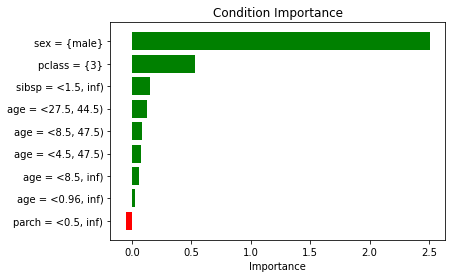

In [75]:
y_test_nn_df = pd.DataFrame(y_test_nn_decisions, columns=["label"])
X_test_org.reset_index(inplace=True, drop=True)

local_explainability = explainer.local_explainability(X_test_org.iloc[10, :], y_test_nn_df.iloc[10, :], plot = True)

Looking at the local explainability for an example from a test set, returned by the RuleXAI library, it can be seen what rules explaining the black-box model cover the given example. The chart of the importance of the conditions also shows that the condition Sex = {male} had the greatest influence on the model making such a decision. Subsequently, the fact that a given person did not survive was due to the fact that they traveled 3rd class and had more than 1 relative on board

## SHAP

In order to compare the results and conclusions of the explainability of the black-box model with the help of the RuleXAI library, it was decided to explain the model also with the help of the SHAP library [https://shap.readthedocs.io/en/latest/index.html]. The SHAP library is one of the currently most popular and widely used libraries for black-box model explainability.

In [106]:
import shap
shap.initjs()

In [107]:
explainer = shap.DeepExplainer(model,X_train)
shap_values = explainer.shap_values(X_train.values)

### Global ranking

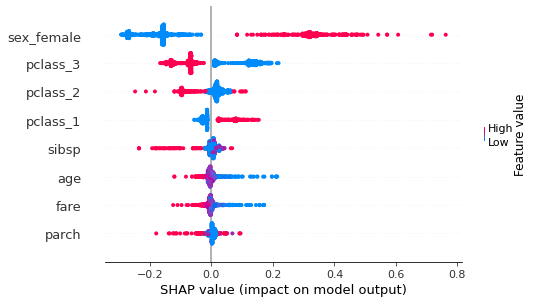

In [108]:
shap.summary_plot(shap_values[0], X_train)

Comparing the ranking obtained using the SHAP library with the rankings obtained using the RuleXAI library, similar conclusions can be reached. The biggest influence on whether a person survived was whether person was female or not. The next most important attributes concern which class the person traveled in. These conclusions are in line with those drawn on the basis of the ranking obtained with the RuleXAI library.

### Local explainability

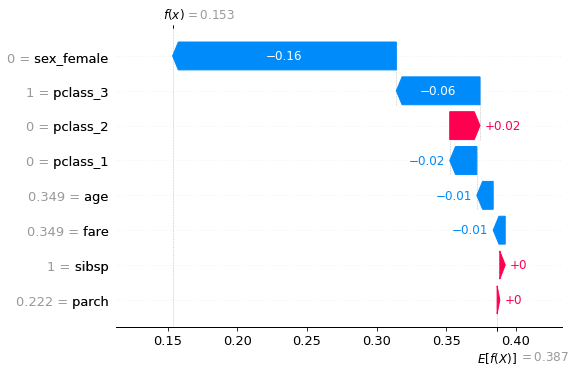

In [109]:
shap_values = explainer.shap_values(X_test.values)
shap.plots.waterfall(shap.Explanation(values=shap_values[0][0], 
                base_values=np.array(explainer.expected_value)[0], 
                data=X_test.iloc[10],
                feature_names=X_test.columns.tolist()))

Comparing the local explainability for the same example obtained using the RuleXAI library and SHAP, similar conclusions can be made: the greatest influence on the decision made by the model for this example was that the person was male. This was followed by the influence that the person was traveling 3rd class.    
Care must be taken when interpreting this graph as the input values of the black-box model, were scaled.